In [20]:
from leap_ec.probe import FitnessStatsCSVProbe
from leap_ec.contrib import analysis
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats

plt.style.use('ggplot')

In [21]:
!mkdir -p ./figures

# Exponential Landscapes

In [22]:
def load_runs(pop_size):
    dir_prefix = '2022-03-07_initialization_strategies_results/'
    
    def load_file(name):
        df_ = pd.read_csv(f"{dir_prefix}/{name}", skipinitialspace=True, comment='#')
        assert(len(df_.job.unique()) == 100)
        assert(len(df_.step.unique()) == 5000/10)
        return df_
    
    df_combined = pd.concat([
        load_file(f"extra_popsize{pop_size}.csv"),
        load_file(f"immediate_popsize{pop_size}.csv"),
        load_file(f"until_all_popsize{pop_size}.csv")
    ])
    return df_combined

df = load_runs(pop_size=10)
df

,experiment,job,step,bsf,mean_fitness,std_fitness,min_fitness,max_fitness,time,birth,mean_eval_time,diversity
0,extra,0,0,1.119658e+00,2.993013e-01,3.641840e-01,4.447460e-03,1.119658e+00,1.472524e+00,20,2.993013e-01,2343.262769
1,extra,0,10,3.042902e+00,2.244271e+00,6.629374e-01,1.557585e+00,3.042902e+00,5.147415e+00,30,2.244271e+00,2478.837987
2,extra,0,20,6.872073e+00,6.463177e+00,1.046710e+00,3.340503e+00,6.872073e+00,1.001554e+01,40,6.463177e+00,1165.563887
3,extra,0,30,1.253861e+01,1.187303e+01,1.678362e+00,6.872073e+00,1.253861e+01,1.892455e+01,50,1.187303e+01,1103.585006
4,extra,0,40,1.887584e+01,1.758895e+01,6.666268e-01,1.675175e+01,1.887584e+01,3.586628e+01,60,1.758895e+01,1027.234971
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,until_all_evaluating,99,4950,4.851652e+08,4.851652e+08,5.960464e-08,4.851652e+08,4.851652e+08,1.591487e+11,4961,4.851652e+08,0.000000
49996,until_all_evaluating,99,4960,4.851652e+08,4.851652e+08,5.960464e-08,4.851652e+08,4.851652e+08,1.593662e+11,4971,4.851652e+08,0.000000
49997,until_all_evaluating,99,4970,4.851652e+08,4.851652e+08,5.960464e-08,4.851652e+08,4.851652e+08,1.597174e+11,4981,4.851652e+08,0.000000
49998,until_all_evaluating,99,4980,4.851652e+08,4.851652e+08,5.960464e-08,4.851652e+08,4.851652e+08,1.601190e+11,4991,4.851652e+08,0.000000


In [23]:
def triple_plot(df, pop_size):
    time_col = 'step'
    modulo = 50
    max_time = float('inf')
    df = df[df[time_col] % modulo == 0]  # Select every nth step
    df = df[df[time_col] < max_time]  # Cut off end of runs

    analyzer = analysis.CurveAnalyzer(df,
                                      time_col=time_col,
                                      experiment_cols=['experiment'],
                                      metric_cols=FitnessStatsCSVProbe.default_metric_cols)
    plotter = analysis.CurvePlotter(analyzer)
    metric_col = 'bsf'
    ylog=False
    error=True
    ylim=(None, None)

    plt.figure(figsize=(12, 6))
    #plt.subplot(131)
    #plotter.plot_curves(metric_col, f"Indiviudal {metric_col} Curves", ylog=ylog, ax=plt.gca())
    plt.subplot(121)
    plotter.plot_avg_curves(metric_col, f"Average {metric_col} Curves", error, ylim, ylog=ylog, ax=plt.gca())
    plt.ylabel("Mean Fitness")
    plt.title(f"BSF when Population Size = #Processors = {pop_size}")
    plt.subplot(122)
    plotter.plot_scalars_bar(metric_col, title='Area Under Curve', ax=plt.gca())
    plt.xlabel("")
    plt.tight_layout()
    
    return analyzer.scalar_metrics_per_run(metric_col=metric_col)
    

### Pop-size = 10

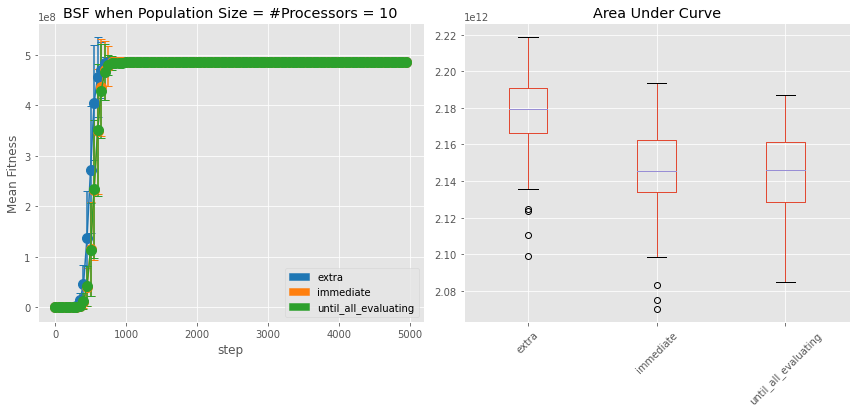

In [24]:
df = load_runs(pop_size=10)
df_auc = triple_plot(df, pop_size=10)
plt.savefig('./figures/2022-03_initialization_n_equals_t_equals_10.pdf', format='pdf')

In [6]:
df_auc.groupby(['experiment']).auc.mean()

experiment
extra                   2.176306e+12
immediate               2.144345e+12
until_all_evaluating    2.144193e+12
Name: auc, dtype: float64

In [7]:
stats.ranksums(
    df_auc[df_auc.experiment == 'extra'].auc,
    df_auc[df_auc.experiment == 'immediate'].auc
)

RanksumsResult(statistic=8.940359937994415, pvalue=3.879048191157542e-19)

In [8]:
stats.ranksums(
    df_auc[df_auc.experiment == 'extra'].auc,
    df_auc[df_auc.experiment == 'until_all_evaluating'].auc
)

RanksumsResult(statistic=8.83773760473512, pvalue=9.767635091594961e-19)

In [9]:
stats.ranksums(
    df_auc[df_auc.experiment == 'immediate'].auc,
    df_auc[df_auc.experiment == 'until_all_evaluating'].auc
)

RanksumsResult(statistic=0.0048867777742522085, pvalue=0.9961009309805384)

### Pop-size = 50

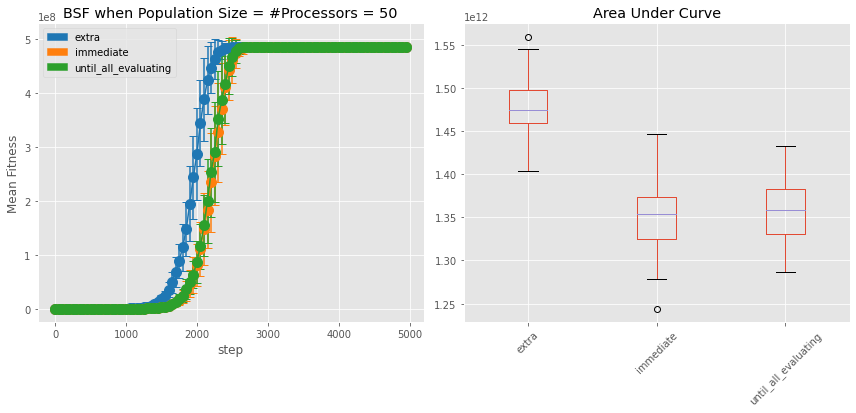

In [10]:
df = load_runs(pop_size=50)
df_auc = triple_plot(df, pop_size=50)
plt.savefig('./figures/2022-03_initialization_n_equals_t_equals_50.pdf', format='pdf')

In [11]:
df_auc.groupby(['experiment']).auc.mean()

experiment
extra                   1.477689e+12
immediate               1.351257e+12
until_all_evaluating    1.358103e+12
Name: auc, dtype: float64

In [12]:
stats.ranksums(
    df_auc[df_auc.experiment == 'extra'].auc,
    df_auc[df_auc.experiment == 'immediate'].auc
)

RanksumsResult(statistic=12.106991935709848, pvalue=9.698606209323647e-34)

In [13]:
stats.ranksums(
    df_auc[df_auc.experiment == 'extra'].auc,
    df_auc[df_auc.experiment == 'until_all_evaluating'].auc
)

RanksumsResult(statistic=12.104548546822722, pvalue=9.991757085418395e-34)

In [14]:
stats.ranksums(
    df_auc[df_auc.experiment == 'immediate'].auc,
    df_auc[df_auc.experiment == 'until_all_evaluating'].auc
)

RanksumsResult(statistic=-1.2534584990956916, pvalue=0.21003889340124926)

### Pop-size = 100

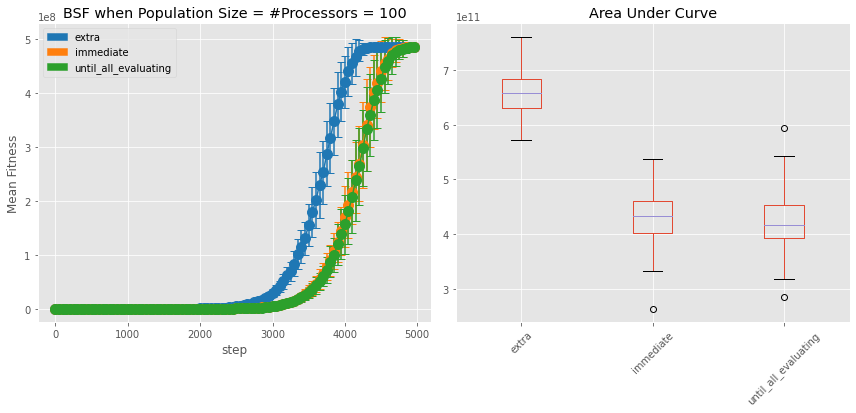

In [15]:
df = load_runs(pop_size=100)
df_auc = triple_plot(df, pop_size=100)
plt.savefig('./figures/2022-03_initialization_n_equals_t_equals_100.pdf', format='pdf')

In [16]:
df_auc.groupby(['experiment']).auc.mean()

experiment
extra                   6.563292e+11
immediate               4.286526e+11
until_all_evaluating    4.196141e+11
Name: auc, dtype: float64

In [17]:
stats.ranksums(
    df_auc[df_auc.experiment == 'extra'].auc,
    df_auc[df_auc.experiment == 'immediate'].auc
)

RanksumsResult(statistic=12.216944435630522, pvalue=2.5239394239903128e-34)

In [18]:
stats.ranksums(
    df_auc[df_auc.experiment == 'extra'].auc,
    df_auc[df_auc.experiment == 'until_all_evaluating'].auc
)

RanksumsResult(statistic=12.207170880082018, pvalue=2.8461468543672125e-34)

In [19]:
stats.ranksums(
    df_auc[df_auc.experiment == 'immediate'].auc,
    df_auc[df_auc.experiment == 'until_all_evaluating'].auc
)

RanksumsResult(statistic=1.5026841655825542, pvalue=0.13292050786006737)